# 23_04_25_03_erythroid_lineage_下游分析2_CellDancer对于基因的描述

In [1]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import anndata as ad
import scanpy as sc
import scvelo as scv
import velovgi

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 读取结果

In [2]:
# adata_dir = "tmp/erythroid_lineage/adata"
adata_dir = "tmp/erythroid_lineage2/adata"
adata = velovgi.tl.read_adata(adata_dir)
batch_key = "stage"
cluster_key = "celltype"
adata

load tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

2. subsample_adata

In [13]:
subsample_adata = scv.read("./tmp/erythroid_lineage2/subsample_adata.h5ad")
subsample_adata

AnnData object with n_obs × n_vars = 250 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovi', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

3. model

In [41]:
# velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage/model", adata=adata, use_gpu=True)
velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage2/model", adata=adata, use_gpu=True)

INFO     File tmp/erythroid_lineage2/model/model.pt already downloaded                                             


## 2. 对应Fig2e

In [204]:
time_key = "latent_time"

1. 基因表达热图1：之前需要添加时间,但模型得到的是一个细胞*基因的矩阵,直接对行取平均,得到的效果不太好。

In [205]:
velovgi.pp.moment_layer_attribute(adata, subsample_adata, attribute="fit_t")
adata.obs[time_key] = adata.layers["fit_t"].mean(axis=1).A[:, 0]
adata

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'latent_time', 'latent_time_categorical'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover', '_scvi_uuid', '_scvi_manager_uuid', 'latent_time_categorical_colors', 'latent_time_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity', 'fit_t'
    obsp: 'connectivities', 'distances'

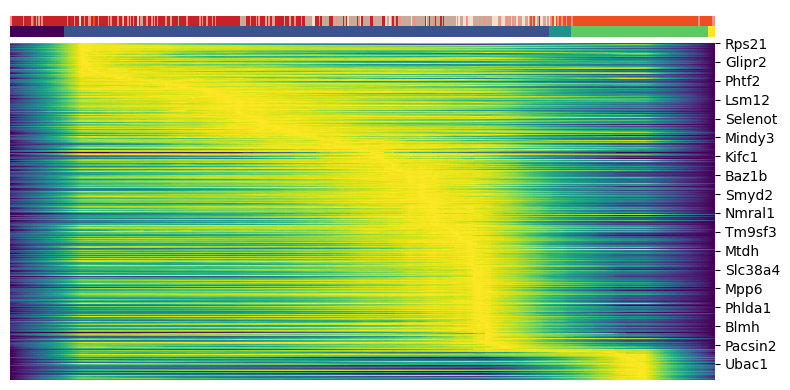

In [206]:
# velovgi_model.get_gene_likelihood(subsample_adata)
top_genes = list(adata.var.index[:2000]) # 这里top_gene暂时这也写,以后可以用marker基因看，或者皮尔森相关系数>0.8(CellDancer)
scv.pl.heatmap(adata, var_names=top_genes, sortby=time_key, col_color=[cluster_key, time_key], n_convolve=100)

2. 基因表达热图2：只能手动给个大概的时间顺序

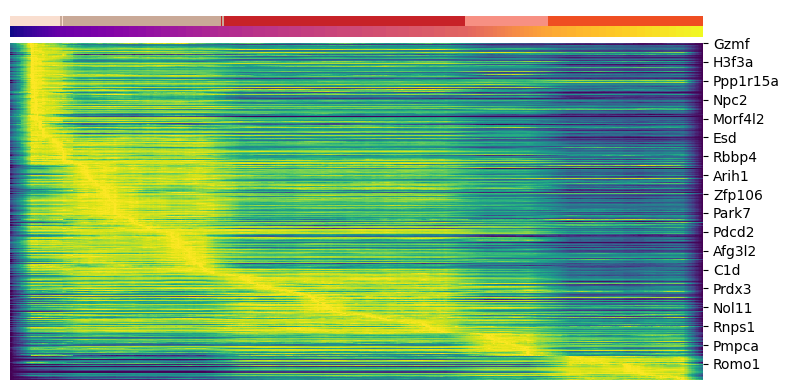

In [207]:
import numpy as np


latent_time = np.zeros(adata.obs.shape[0])

# 离散的时间序列
# cluster2time = {
#     "Blood progenitors 1" : 5,
#     "Blood progenitors 2" : 10,
#     "Erythroid1" : 15,
#     "Erythroid2" : 20,
#     "Erythroid3" : 25,
# }
# adata.obs["latent_time"] = adata.obs[cluster_key].apply(lambda x: cluster2time[x])
# adata.obs["latent_time"] = adata.obs["latent_time"].astype("int")
# 连续的时间序列

# 连续的时间序列，每个聚类的时间随机分配
cluster_list = ["Blood progenitors 1", "Blood progenitors 2", "Erythroid1", "Erythroid2", "Erythroid3"]
time_list = [5,10,15,20,25]
for i in range(len(cluster_list)):
    cluster = cluster_list[i]
    time = time_list[i]
    pre_time = time_list[i-1] if i>0 else 0
    bool_series = adata.obs[cluster_key] == cluster # 提取指定类型
    latent_time[bool_series] = np.linspace(pre_time,time, bool_series.sum()) # 设置时间范围
adata.obs[time_key] = latent_time

scv.pl.heatmap(adata, var_names=top_genes, sortby=time_key, col_color=[cluster_key, time_key], palette="plasma", cbar_pos=(0.02, 0.8, 0.05, 0.18))

3. 单看转录爆发基因的热图，都是在最后的细胞类型中

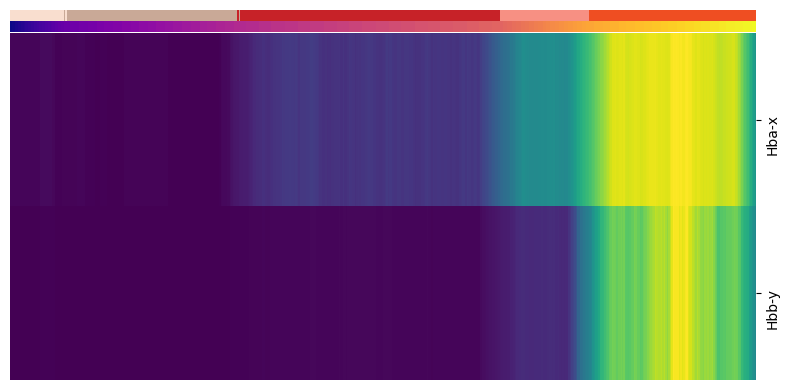

In [208]:
top_genes = ["Hba-x", "Hbb-y"]
ax = scv.pl.heatmap(adata, var_names=top_genes, sortby=time_key, col_color=[cluster_key, time_key], colorbar=True, palette="plasma", show=False)

4. 美化（修改原函数）
    - 添加colorbar
    - 聚类结果添加

In [236]:
# import numpy as np
# import pandas as pd
# from scipy.sparse import issparse

# from scvelo import logging as logg
# from scvelo.plotting.utils import (
#     interpret_colorkey,
#     is_categorical,
#     savefig_or_show,
#     set_colors_for_categorical_obs,
#     strings_to_categoricals,
#     to_list,
# )


# def heatmap(
#     adata,
#     var_names,
#     sortby="latent_time",
#     layer="Ms",
#     color_map="viridis",
#     col_color=None,
#     palette="viridis",
#     n_convolve=30,
#     standard_scale=0,
#     sort=True,
#     colorbar=None,
#     col_cluster=False,
#     row_cluster=False,
#     context=None,
#     font_scale=None,
#     figsize=(8, 4),
#     show=None,
#     save=None,
#     **kwargs,
# ):
#     """Plot time series for genes as heatmap.
#     Arguments
#     ---------
#     adata: :class:`~anndata.AnnData`
#         Annotated data matrix.
#     var_names: `str`,  list of `str`
#         Names of variables to use for the plot.
#     sortby: `str` (default: `'latent_time'`)
#         Observation key to extract time data from.
#     layer: `str` (default: `'Ms'`)
#         Layer key to extract count data from.
#     color_map: `str` (default: `'viridis'`)
#         String denoting matplotlib color map.
#     col_color: `str` or list of `str` (default: `None`)
#         String denoting matplotlib color map to use along the columns.
#     palette: list of `str` (default: `'viridis'`)
#         Colors to use for plotting groups (categorical annotation).
#     n_convolve: `int` or `None` (default: `30`)
#         If `int` is given, data is smoothed by convolution
#         along the x-axis with kernel size n_convolve.
#     standard_scale : `int` or `None` (default: `0`)
#         Either 0 (rows) or 1 (columns). Whether or not to standardize that dimension
#         (each row or column), subtract minimum and divide each by its maximum.
#     sort: `bool` (default: `True`)
#         Wether to sort the expression values given by xkey.
#     colorbar: `bool` or `None` (default: `None`)
#         Whether to show colorbar.
#     {row,col}_cluster : `bool` or `None`
#         If True, cluster the {rows, columns}.
#     context : `None`, or one of {paper, notebook, talk, poster}
#         A dictionary of parameters or the name of a preconfigured set.
#     font_scale : float, optional
#         Scaling factor to scale the size of the font elements.
#     figsize: tuple (default: `(8,4)`)
#         Figure size.
#     show: `bool`, optional (default: `None`)
#         Show the plot, do not return axis.
#     save: `bool` or `str`, optional (default: `None`)
#         If `True` or a `str`, save the figure. A string is appended to the default
#         filename. Infer the filetype if ending on {'.pdf', '.png', '.svg'}.
#     kwargs:
#         Arguments passed to seaborns clustermap,
#         e.g., set `yticklabels=True` to display all gene names in all rows.
#     Returns
#     -------
#     If `show==False` a `matplotlib.Axis`
#     """
#     import seaborn as sns

#     var_names = [name for name in var_names if name in adata.var_names]

#     tkey, xkey = kwargs.pop("tkey", sortby), kwargs.pop("xkey", layer)
#     time = adata.obs[tkey].values
#     time = time[np.isfinite(time)]

#     X = (
#         adata[:, var_names].layers[xkey]
#         if xkey in adata.layers.keys()
#         else adata[:, var_names].X
#     )
#     if issparse(X):
#         X = X.A
#     df = pd.DataFrame(X[np.argsort(time)], columns=var_names)

#     if n_convolve is not None:
#         weights = np.ones(n_convolve) / n_convolve
#         for gene in var_names:
#             # TODO: Handle exception properly
#             try:
#                 df[gene] = np.convolve(df[gene].values, weights, mode="same")
#             except ValueError as e:
#                 logg.info(f"Skipping variable {gene}: {e}")
#                 pass  # e.g. all-zero counts or nans cannot be convolved

#     if sort:
#         max_sort = np.argsort(np.argmax(df.values, axis=0))
#         df = pd.DataFrame(df.values[:, max_sort], columns=df.columns[max_sort])
#     strings_to_categoricals(adata)

#     if col_color is not None:
#         col_colors = to_list(col_color)
#         col_color = []
#         for _, col in enumerate(col_colors):
#             if not is_categorical(adata, col):
#                 obs_col = adata.obs[col]
#                 cat_col = np.round(obs_col / np.max(obs_col), 2) * np.max(obs_col)
#                 adata.obs[f"{col}_categorical"] = pd.Categorical(cat_col)
#                 col += "_categorical"
#                 set_colors_for_categorical_obs(adata, col, palette)
#             col_color.append(interpret_colorkey(adata, col)[np.argsort(time)])

#     if "dendrogram_ratio" not in kwargs:
#         kwargs["dendrogram_ratio"] = (
#             0.1 if row_cluster else 0,
#             0.2 if col_cluster else 0,
#         )
#     if "cbar_pos" not in kwargs or not colorbar:
#         kwargs["cbar_pos"] = None
#     kwargs.update(
#         {
#             "col_colors": col_color,
#             "col_cluster": col_cluster,
#             "row_cluster": row_cluster,
#             "cmap": color_map,
#             "xticklabels": False,
#             "standard_scale": standard_scale,
#             "figsize": figsize,
#         }
#     )

#     args = {}
#     if font_scale is not None:
#         args = {"font_scale": font_scale}
#         context = context or "notebook"

#     with sns.plotting_context(context=context, **args):
#         # TODO: Remove exception by requiring appropriate seaborn version
#         try:
#             cm = sns.clustermap(df.T, **kwargs)
#         except ImportWarning:
#             logg.warn("Please upgrade seaborn with `pip install -U seaborn`.")
#             kwargs.pop("dendrogram_ratio")
#             kwargs.pop("cbar_pos")
#             cm = sns.clustermap(df.T, **kwargs)

#     savefig_or_show("heatmap", save=save, show=show)
#     if show is False:
#         return cm

In [237]:
# heatmap(adata, var_names=top_genes, sortby=time_key, col_color=[cluster_key, time_key], palette="plasma", colorbar=True ,cbar_pos=(0.02, 0.8, 0.05, 0.18))

## 对应Fig2f

1. 对基因聚类

2. 曲线图

3. 富集分析图

## 对应Fig2c

1. 损失

2. 